# Bank Marketing Campaign Classification

This notebook builds a classification pipeline to predict whether a customer will subscribe to a term deposit based on the UCI Bank Marketing dataset.

## Imports

In [1]:
# Standard library
from pathlib import Path
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Scikit-learn: preprocessing and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model interpretability
import shap

# Configuration
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load Data

Configure project paths and load the Bank Marketing dataset.

In [2]:
# Resolve project paths
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

# Define directory structure
DATA_DIR = PROJECT_ROOT / "datasets" / "bank-marketing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"

# Create output directories
for path in [PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")

Project root: /Users/xuguangjie/Desktop/PhD Courses/博二上/数据挖掘/大作业/data-mining
Outputs directory: /Users/xuguangjie/Desktop/PhD Courses/博二上/数据挖掘/大作业/data-mining/outputs


In [3]:
# Load dataset
data_path = DATA_DIR / "bank-full.csv"
df_raw = pd.read_csv(data_path, sep=";")

print(f"Loaded {df_raw.shape[0]:,} rows and {df_raw.shape[1]} columns")
print(f"\nTarget distribution:")
print(df_raw["y"].value_counts(normalize=True).rename("proportion").to_string())
print(f"\nClass imbalance ratio: {df_raw['y'].value_counts()['no'] / df_raw['y'].value_counts()['yes']:.2f}:1")

Loaded 45,211 rows and 17 columns

Target distribution:
y
no     0.883015
yes    0.116985

Class imbalance ratio: 7.55:1


## Preprocessing

### Outlier Removal
Remove extreme outliers (z-score > 3) from numeric columns to reduce noise.

In [4]:
# Remove outliers using z-score method
# IMPROVED: Less aggressive outlier removal (z > 4 instead of z > 3)
# Keeps more edge cases that may contain valuable signal
df = df_raw.copy()
outlier_cols = ["balance", "age", "campaign"]

# Drop duration column - it's only known after a call ends (data leakage)
df = df.drop(columns=["duration"])

# Create a combined mask for all outlier conditions (relaxed threshold)
outlier_mask = pd.Series(True, index=df.index)
for col in outlier_cols:
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    outlier_mask &= (z_scores < 4)  # Changed from 3 to 4 (less aggressive)

df = df[outlier_mask].reset_index(drop=True)

print(f"Rows before: {df_raw.shape[0]:,}")
print(f"Rows after outlier removal: {df.shape[0]:,}")
print(f"Rows removed: {df_raw.shape[0] - df.shape[0]:,} ({100 * (1 - df.shape[0] / df_raw.shape[0]):.1f}%)")
print(f"\nNote: 'duration' column dropped (only known post-call, causes data leakage)")

Rows before: 45,211
Rows after outlier removal: 44,220
Rows removed: 991 (2.2%)

Note: 'duration' column dropped (only known post-call, causes data leakage)


In [5]:
# Separate features and target
X = df.drop(columns="y")
y = df["y"].map({"yes": 1, "no": 0})

# Identify column types
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")

Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric features (6): ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']


## Feature Engineering

Create domain-specific features to improve model predictive power.

**Note**: The `duration` feature was removed from the dataset as it represents call duration, which is only known after a call ends and would cause data leakage in a real prediction scenario.

In [6]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # -1 means never contacted, don't use 999 which creates outliers
    df["was_contacted_before"] = (df["pdays"] != -1).astype(int)
    
    # For those contacted before, use log transform (adds 1 to avoid log(0))
    # For never contacted, use median of contacted group
    contacted_mask = df["pdays"] != -1
    if contacted_mask.sum() > 0:
        median_pdays = df.loc[contacted_mask, "pdays"].median()
        df["pdays_transformed"] = df["pdays"].replace(-1, median_pdays)
        df["pdays_log"] = np.log1p(df["pdays_transformed"])
    else:
        df["pdays_log"] = 0
    
    # Recency buckets, more informative than raw days
    df["contact_recency"] = pd.cut(
        df["pdays"].replace(-1, 9999),
        bins=[-1, 7, 30, 90, 180, 365, 10000],
        labels=["week", "month", "quarter", "half_year", "year", "never"]
    ).astype(str)
    
    # Previous campaign success is extremely predictive (~65% conversion if success)
    df["prev_success"] = (df["poutcome"] == "success").astype(int)
    df["prev_failure"] = (df["poutcome"] == "failure").astype(int)
    df["prev_unknown"] = (df["poutcome"] == "unknown").astype(int)
    
    # Interaction: contacted before AND had success
    df["contacted_and_success"] = (df["was_contacted_before"] & df["prev_success"]).astype(int)
    
    # === Contact history features ===
    df["contact_intensity"] = df["campaign"] / (df["previous"] + 1)
    df["total_contacts"] = df["campaign"] + df["previous"]
    df["high_campaign_effort"] = (df["campaign"] > df["campaign"].median()).astype(int)
    
    # === Financial features ===
    df["balance_per_age"] = df["balance"] / (df["age"] + 1)
    df["has_positive_balance"] = (df["balance"] > 0).astype(int)
    df["has_high_balance"] = (df["balance"] > df["balance"].quantile(0.75)).astype(int)
    df["has_loan_or_default"] = ((df["loan"] == "yes") | (df["default"] == "yes")).astype(int)
    
    # === Demographic interactions ===
    df["young_single"] = ((df["age"] < 30) & (df["marital"] == "single")).astype(int)
    df["retired_age"] = (df["age"] >= 60).astype(int)
    
    # === Time-based features ===
    if "day" in df.columns:
        df["is_month_start"] = (df["day"] <= 10).astype(int)
        df["is_month_end"] = (df["day"] >= 20).astype(int)
    
    # Month seasonality (certain months have higher conversion)
    high_conversion_months = ["mar", "oct", "sep", "dec"]
    df["is_high_conversion_month"] = df["month"].isin(high_conversion_months).astype(int)
    
    # Drop intermediate columns
    df = df.drop(columns=["pdays_transformed"], errors="ignore")
    
    return df


# Apply feature engineering
X_engineered = engineer_features(X)

new_features = set(X_engineered.columns) - set(X.columns)
print(f"Original features: {len(X.columns)}")
print(f"Engineered features: {len(X_engineered.columns)}")
print(f"New features added ({len(new_features)}): {sorted(new_features)}")

Original features: 15
Engineered features: 34
New features added (19): ['balance_per_age', 'contact_intensity', 'contact_recency', 'contacted_and_success', 'has_high_balance', 'has_loan_or_default', 'has_positive_balance', 'high_campaign_effort', 'is_high_conversion_month', 'is_month_end', 'is_month_start', 'pdays_log', 'prev_failure', 'prev_success', 'prev_unknown', 'retired_age', 'total_contacts', 'was_contacted_before', 'young_single']


In [7]:
# Update column lists for engineered features
categorical_cols_eng = X_engineered.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols_eng = X_engineered.select_dtypes(include=["number"]).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols_eng),
        ("num", StandardScaler(), numeric_cols_eng),
    ]
)

print(f"Categorical features: {len(categorical_cols_eng)}")
print(f"Numeric features: {len(numeric_cols_eng)}")

Categorical features: 10
Numeric features: 24


### Train/Test Split

Use stratified split to preserve class distribution in both sets.

In [8]:
# Stratified train/validation/test split
# First split: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_engineered, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Second split: train vs validation (75/25 of remaining = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Calculate class weight for imbalanced learning
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Training set: {X_train.shape[0]:,} samples (60%)")
print(f"Validation set: {X_val.shape[0]:,} samples (20%) - for early stopping")
print(f"Test set: {X_test.shape[0]:,} samples (20%)")
print(f"Positive class weight: {pos_weight:.2f}")
print(f"\nTrain class distribution:")
print(y_train.value_counts(normalize=True).rename({0: "no", 1: "yes"}).to_string())

Training set: 26,532 samples (60%)
Validation set: 8,844 samples (20%) - for early stopping
Test set: 8,844 samples (20%)
Positive class weight: 7.50

Train class distribution:
y
no     0.882331
yes    0.117669


### Helper Functions

Utility functions for threshold optimization and model evaluation.

In [9]:
def find_optimal_threshold(y_true: np.ndarray, y_proba: np.ndarray) -> tuple[float, float]:
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Calculate F1 for each threshold (avoid division by zero)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Find best threshold (precision_recall_curve returns n+1 values, last has no threshold)
    best_idx = np.argmax(f1_scores[:-1])
    return thresholds[best_idx], f1_scores[best_idx]


def evaluate_model(
    name: str, 
    y_true: np.ndarray, 
    y_proba: np.ndarray, 
    threshold: float = None
) -> dict:
    if threshold is None:
        threshold, _ = find_optimal_threshold(y_true, y_proba)
    
    y_pred = (y_proba >= threshold).astype(int)
    
    metrics = {
        "name": name,
        "threshold": threshold,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "predictions": y_pred,
        "probabilities": y_proba,
    }
    
    print(f"\n{'='*50}")
    print(f"{name} @ threshold {threshold:.3f}")
    print(f"{'='*50}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

## Model Training

Train multiple classifiers with different approaches to handle class imbalance:
1. **Class weights**: Built-in parameter to penalize misclassification of minority class
2. **SMOTE**: Synthetic Minority Over-sampling Technique to balance training data

### Logistic Regression (Baseline)

In [90]:
# Store all results for comparison
all_results = []

# Logistic Regression with class weights
log_reg_pipeline = Pipeline([
    ("preprocessor", clone(preprocessor)),
    ("classifier", LogisticRegression(
        max_iter=1000, 
        class_weight="balanced",
        C=0.1,
        random_state=RANDOM_STATE
    )),
])

log_reg_pipeline.fit(X_train, y_train)
log_reg_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]
log_reg_results = evaluate_model("Logistic Regression", y_test, log_reg_proba)
all_results.append(log_reg_results)


Logistic Regression @ threshold 0.649
  Accuracy:  0.8703
  Precision: 0.4498
  Recall:    0.4563
  F1 Score:  0.4530
  ROC AUC:   0.7831


### Manually implementation: Classification Tree

In [17]:
import DecisionTree as dt 
# find the best model
# max_depth_list = range(5,21,2)
# min_sample_list = range(5,21)
# best_evaluation_loss = 1e4
# best_max_depth = 0
# best_min_sample = 0
# best_preds = np.full_like(y_test,0.0,dtype=float)
# best_tree = None
# for max_depth in max_depth_list:
#     for min_sample in min_sample_list:
#         clstree = dt.ClassificationTree(loss_function="Entropy", leaf_value_estimator="most_common_vote", max_depth=max_depth, min_sample=min_sample)
#         clstree.fit(X_train, y_train)
#         clstree.prune(X_val, y_val)
#         y_preds = clstree.predict_batch(X_test)
#         current_evaluation_loss = np.sum(y_preds != y_test)
#         if current_evaluation_loss < best_evaluation_loss:
#             best_evaluation_loss = current_evaluation_loss
#             best_max_depth = max_depth 
#             best_min_sample = min_sample
#             best_preds = y_preds
#             best_tree = clstree

# evaluate_model("Classificationtree", y_test, best_preds)
clstree = dt.ClassificationTree(max_depth=5)
clstree.fit(X_train,y_train)
# 跑得太慢了，，，，，修改ing

In [15]:
clstree.prune(X_val,y_val)

In [16]:
y_preds = clstree.predict_batch(X_test)
evaluate_model("Classificationtree", y_test, y_preds)


Classificationtree @ threshold 1.000
  Accuracy:  0.8947
  Precision: 0.6763
  Recall:    0.2027
  F1 Score:  0.3119
  ROC AUC:   0.5949


{'name': 'Classificationtree',
 'threshold': np.int64(1),
 'accuracy': 0.8947308909995477,
 'precision': 0.6762820512820513,
 'recall': 0.2026897214217099,
 'f1': 0.31189948263118994,
 'roc_auc': 0.5948729909171858,
 'predictions': array([0, 1, 0, ..., 0, 0, 0], shape=(8844,)),
 'probabilities': array([0, 1, 0, ..., 0, 0, 0], shape=(8844,))}

### XGBoost with SMOTE

In [91]:
# XGBoost with SMOTE and early stopping

preprocessor_fitted = clone(preprocessor).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_val_transformed = preprocessor_fitted.transform(X_val)
X_test_transformed = preprocessor_fitted.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

print(f"Training samples before SMOTE: {X_train_transformed.shape[0]:,}")
print(f"Training samples after SMOTE: {X_train_smote.shape[0]:,}")

xgb_model = XGBClassifier(
    n_estimators=1000,  # High value, early stopping will find optimal
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.15,
    reg_alpha=0.1,
    reg_lambda=1.5,
    objective="binary:logistic",
    eval_metric="auc",  # Use AUC for imbalanced data
    random_state=RANDOM_STATE,
    tree_method="hist",
    early_stopping_rounds=50,
)

xgb_model.fit(
    X_train_smote, y_train_smote,
    eval_set=[(X_val_transformed, y_val)],
    verbose=False
)

print(f"Best iteration: {xgb_model.best_iteration}")

# Wrapper pipeline for consistency
class XGBSMOTEWrapper:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
    
    def predict_proba(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict_proba(X_transformed)
    
    def predict(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict(X_transformed)

xgb_smote_pipeline = XGBSMOTEWrapper(preprocessor_fitted, xgb_model)

# Evaluate
xgb_smote_proba = xgb_smote_pipeline.predict_proba(X_test)[:, 1]
xgb_smote_results = evaluate_model("XGBoost + SMOTE", y_test, xgb_smote_proba)
all_results.append(xgb_smote_results)

Training samples before SMOTE: 26,532
Training samples after SMOTE: 46,820
Best iteration: 742

XGBoost + SMOTE @ threshold 0.294
  Accuracy:  0.8777
  Precision: 0.4806
  Recall:    0.4870
  F1 Score:  0.4838
  ROC AUC:   0.7988


### Random Forest with SMOTE

In [92]:
# Random Forest with SMOTE
# Reuse transformed and SMOTE'd data from XGBoost cell

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    class_weight="balanced",  # Additional class weighting on top of SMOTE
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_model.fit(X_train_smote, y_train_smote)

rf_smote_pipeline = XGBSMOTEWrapper(preprocessor_fitted, rf_model)

rf_smote_proba = rf_smote_pipeline.predict_proba(X_test)[:, 1]
rf_smote_results = evaluate_model("Random Forest + SMOTE", y_test, rf_smote_proba)
all_results.append(rf_smote_results)


Random Forest + SMOTE @ threshold 0.478
  Accuracy:  0.8648
  Precision: 0.4314
  Recall:    0.4678
  F1 Score:  0.4488
  ROC AUC:   0.7899


### LightGBM with SMOTE

In [93]:
# LightGBM with SMOTE and early stopping
# Reuse transformed data from XGBoost cell

from lightgbm import early_stopping, log_evaluation

lgbm_model = LGBMClassifier(
    n_estimators=1000,  # High value, early stopping will find optimal
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    verbose=-1,
)

lgbm_model.fit(
    X_train_smote, y_train_smote,
    eval_set=[(X_val_transformed, y_val)],
    callbacks=[early_stopping(50, verbose=False), log_evaluation(period=0)],
)

print(f"Best iteration: {lgbm_model.best_iteration_}")

lgbm_smote_pipeline = XGBSMOTEWrapper(preprocessor_fitted, lgbm_model)

lgbm_smote_proba = lgbm_smote_pipeline.predict_proba(X_test)[:, 1]
lgbm_smote_results = evaluate_model("LightGBM + SMOTE", y_test, lgbm_smote_proba)
all_results.append(lgbm_smote_results)

Best iteration: 939

LightGBM + SMOTE @ threshold 0.287
  Accuracy:  0.8791
  Precision: 0.4865
  Recall:    0.4851
  F1 Score:  0.4858
  ROC AUC:   0.7991


/Users/zihanghuang/data-mining/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [94]:
# XGBoost with class weights (scale_pos_weight)
xgb_weighted_pipeline = Pipeline([
    ("preprocessor", clone(preprocessor)),
    ("classifier", XGBClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=5,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.15,
        reg_alpha=0.1,
        reg_lambda=1.5,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        scale_pos_weight=pos_weight,
        tree_method="hist",
    )),
])

xgb_weighted_pipeline.fit(X_train, y_train)
xgb_weighted_proba = xgb_weighted_pipeline.predict_proba(X_test)[:, 1]
xgb_weighted_results = evaluate_model("XGBoost (weighted)", y_test, xgb_weighted_proba)
all_results.append(xgb_weighted_results)


XGBoost (weighted) @ threshold 0.615
  Accuracy:  0.8711
  Precision: 0.4583
  Recall:    0.5226
  F1 Score:  0.4883
  ROC AUC:   0.8015


## Model Comparison

Compare all models across key metrics.

In [95]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ["predictions", "probabilities"]}
    for r in all_results
]).sort_values("f1", ascending=False)

print("\n" + "=" * 80)
print("MODEL COMPARISON (sorted by F1 score)")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Identify best model
best_model_name = comparison_df.iloc[0]["name"]
best_f1 = comparison_df.iloc[0]["f1"]
print(f"\nBest model: {best_model_name} (F1 = {best_f1:.4f})")


MODEL COMPARISON (sorted by F1 score)
                 name  threshold  accuracy  precision   recall       f1  roc_auc
   XGBoost (weighted)   0.614993  0.871099   0.458298 0.522574 0.488330 0.801524
     LightGBM + SMOTE   0.286834  0.879127   0.486513 0.485110 0.485810 0.799096
      XGBoost + SMOTE   0.293652  0.877657   0.480569 0.487032 0.483779 0.798765
  Logistic Regression   0.648507  0.870308   0.449811 0.456292 0.453028 0.783106
Random Forest + SMOTE   0.477928  0.864767   0.431355 0.467819 0.448848 0.789876

Best model: XGBoost (weighted) (F1 = 0.4883)


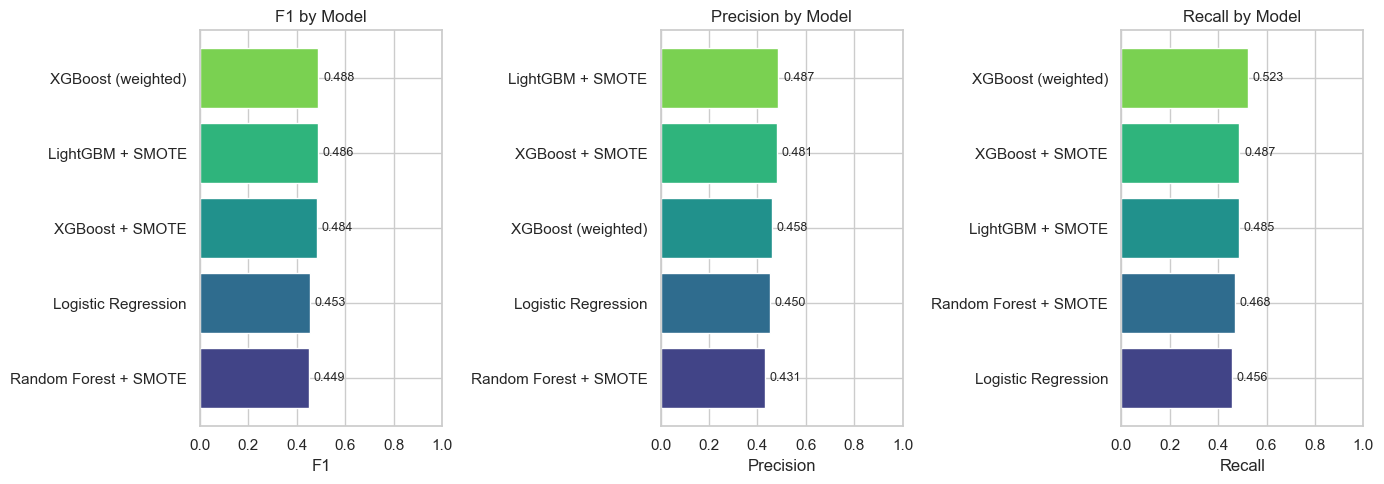

Saved: /Users/zihanghuang/data-mining/outputs/plots/model_comparison.png


In [96]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

metrics_to_plot = ["f1", "precision", "recall"]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))

for ax, metric in zip(axes, metrics_to_plot):
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    bars = ax.barh(sorted_df["name"], sorted_df[metric], color=colors)
    ax.set_xlabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} by Model")
    ax.set_xlim([0, 1])
    
    # Add value labels
    for bar, val in zip(bars, sorted_df[metric]):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                f"{val:.3f}", va="center", fontsize=9)

plt.tight_layout()
comparison_plot_path = PLOTS_DIR / "model_comparison.png"
plt.savefig(comparison_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {comparison_plot_path}")

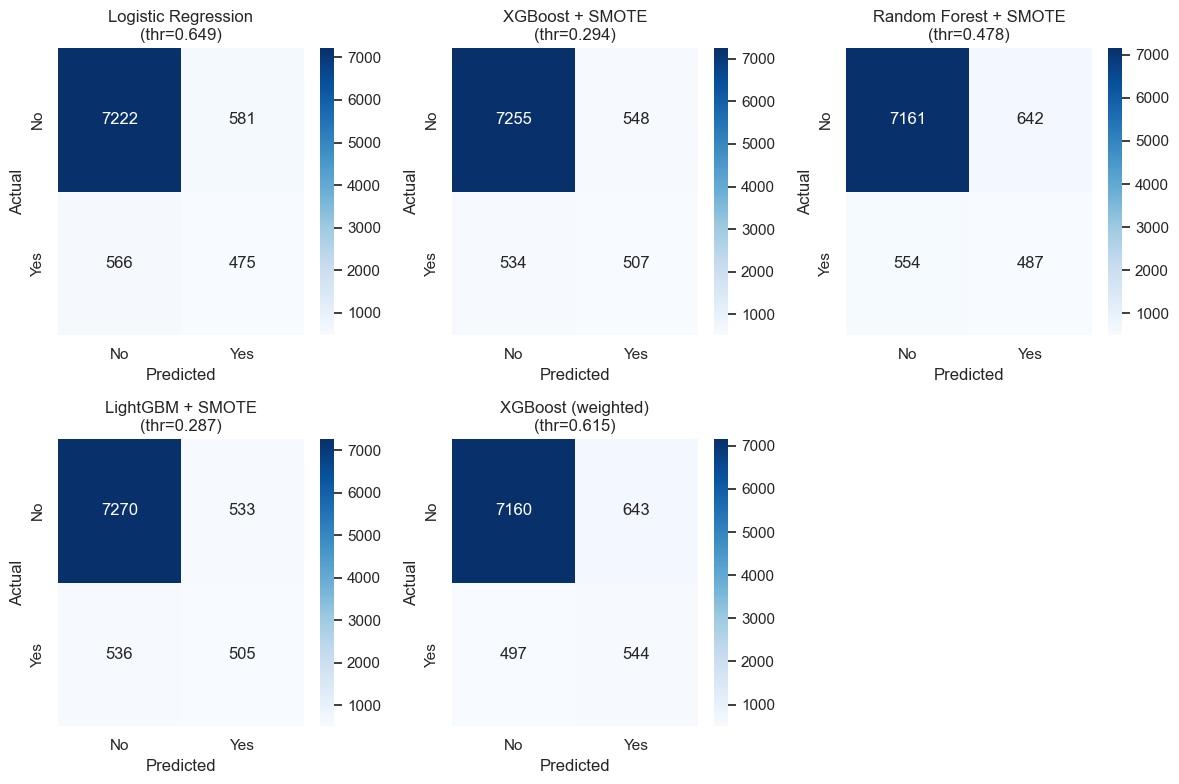

Saved: /Users/zihanghuang/data-mining/outputs/plots/confusion_matrices.png


In [97]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str, ax=None):
    """Plot a confusion matrix with annotations."""
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", ax=ax,
        xticklabels=["No", "Yes"], yticklabels=["No", "Yes"]
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    return ax


# Plot confusion matrices for all models in a grid
n_models = len(all_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    title = f"{result['name']}\n(thr={result['threshold']:.3f})"
    plot_confusion_matrix(y_test, result["predictions"], title, ax=axes[idx])

# Hide unused subplots
for idx in range(len(all_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
cm_plot_path = PLOTS_DIR / "confusion_matrices.png"
plt.savefig(cm_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {cm_plot_path}")

## Model Saving

In [98]:
# Map model names to pipelines
pipelines = {
    "Logistic Regression": log_reg_pipeline,
    "XGBoost (weighted)": xgb_weighted_pipeline,
    "XGBoost + SMOTE": xgb_smote_pipeline,
    "Random Forest + SMOTE": rf_smote_pipeline,
    "LightGBM + SMOTE": lgbm_smote_pipeline,
}

# Save all models with their metadata
for result in all_results:
    model_name = result["name"]
    safe_name = model_name.lower().replace(" ", "_").replace("+", "").replace("(", "").replace(")", "")
    
    pipeline = pipelines[model_name]
    
    # Handle wrapper objects vs sklearn pipelines
    if hasattr(pipeline, 'named_steps'):
        model_to_save = pipeline
    else:
        # For wrapper objects, save the components
        model_to_save = {
            "preprocessor": pipeline.preprocessor,
            "model": pipeline.model,
            "is_wrapper": True
        }
    
    model_data = {
        "pipeline": model_to_save,
        "threshold": result["threshold"],
        "metrics": {k: v for k, v in result.items() if k not in ["predictions", "probabilities"]},
    }
    
    model_path = MODELS_DIR / f"{safe_name}.pkl"
    joblib.dump(model_data, model_path)
    print(f"Saved: {model_path}")

print(f"\nBest model by F1 score: {best_model_name}")

Saved: /Users/zihanghuang/data-mining/outputs/models/logistic_regression.pkl
Saved: /Users/zihanghuang/data-mining/outputs/models/xgboost__smote.pkl
Saved: /Users/zihanghuang/data-mining/outputs/models/random_forest__smote.pkl
Saved: /Users/zihanghuang/data-mining/outputs/models/lightgbm__smote.pkl
Saved: /Users/zihanghuang/data-mining/outputs/models/xgboost_weighted.pkl

Best model by F1 score: XGBoost (weighted)


## Generate Predictions

Export predictions from all models for analysis and comparison.

In [99]:
# Compile predictions from all models
predictions_df = pd.DataFrame({"actual": y_test})

for result in all_results:
    safe_name = result["name"].lower().replace(" ", "_").replace("+", "_").replace("(", "").replace(")", "")
    predictions_df[f"{safe_name}_prob"] = result["probabilities"]
    predictions_df[f"{safe_name}_pred"] = result["predictions"]

# Save predictions
predictions_path = PREDICTIONS_DIR / "classification_predictions.csv"
predictions_df.to_csv(predictions_path, index=False)

print(f"Saved predictions: {predictions_path}")
print(f"Shape: {predictions_df.shape}")
print(f"\nColumns: {list(predictions_df.columns)}")

Saved predictions: /Users/zihanghuang/data-mining/outputs/predictions/classification_predictions.csv
Shape: (8844, 11)

Columns: ['actual', 'logistic_regression_prob', 'logistic_regression_pred', 'xgboost___smote_prob', 'xgboost___smote_pred', 'random_forest___smote_prob', 'random_forest___smote_pred', 'lightgbm___smote_prob', 'lightgbm___smote_pred', 'xgboost_weighted_prob', 'xgboost_weighted_pred']


## Model Interpretability

Use SHAP (SHapley Additive exPlanations) to understand feature importance for the best tree-based model.

In [100]:
# Select best tree-based model for SHAP analysis
tree_models = comparison_df[comparison_df["name"].str.contains("XGBoost|LightGBM|Random Forest")]
best_tree_model = tree_models.iloc[0]["name"]

pipeline_map = {
    "XGBoost (weighted)": xgb_weighted_pipeline,
    "XGBoost + SMOTE": xgb_smote_pipeline,
    "Random Forest + SMOTE": rf_smote_pipeline,
    "LightGBM + SMOTE": lgbm_smote_pipeline,
}

shap_pipeline = pipeline_map[best_tree_model]
print(f"Generating SHAP values for: {best_tree_model}")

# Get feature names and classifier based on pipeline type
if hasattr(shap_pipeline, 'named_steps'):
    # Standard sklearn pipeline
    feature_names = shap_pipeline.named_steps["preprocessor"].get_feature_names_out()
    X_test_transformed = shap_pipeline.named_steps["preprocessor"].transform(X_test)
    classifier = shap_pipeline.named_steps["classifier"]
else:
    # Wrapper object
    feature_names = shap_pipeline.preprocessor.get_feature_names_out()
    X_test_transformed = shap_pipeline.preprocessor.transform(X_test)
    classifier = shap_pipeline.model

# Sample for faster computation
sample_size = min(1000, X_test_transformed.shape[0])
sample_idx = np.random.RandomState(RANDOM_STATE).choice(
    X_test_transformed.shape[0], sample_size, replace=False
)
X_sample = X_test_transformed[sample_idx]

# Convert sparse matrix to dense if needed
if hasattr(X_sample, "toarray"):
    X_sample = X_sample.toarray()

# Create SHAP explainer and compute values
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_sample)

# Handle binary classification output format
# Some models return list [neg_class, pos_class], others return single array
if isinstance(shap_values, list):
    shap_values_display = shap_values[1]  # Use positive class
else:
    shap_values_display = shap_values

print(f"SHAP values shape: {shap_values_display.shape}")

Generating SHAP values for: XGBoost (weighted)
SHAP values shape: (1000, 74)


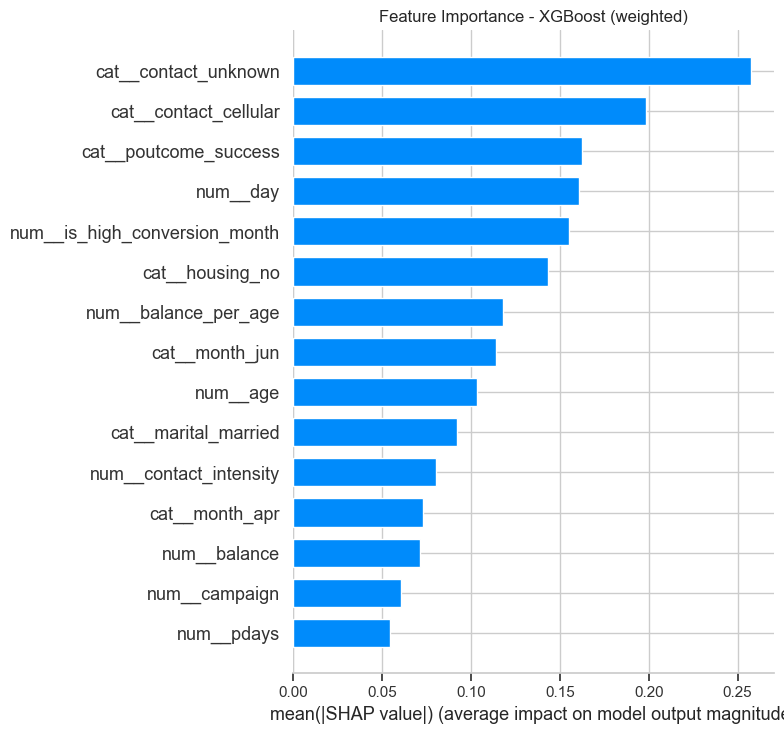

Saved: /Users/zihanghuang/data-mining/outputs/plots/shap_feature_importance.png


In [101]:
# Plot SHAP summary (bar chart)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_display,
    X_sample,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15,
    show=False,
)
plt.title(f"Feature Importance - {best_tree_model}")
plt.tight_layout()
shap_bar_path = PLOTS_DIR / "shap_feature_importance.png"
plt.savefig(shap_bar_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {shap_bar_path}")

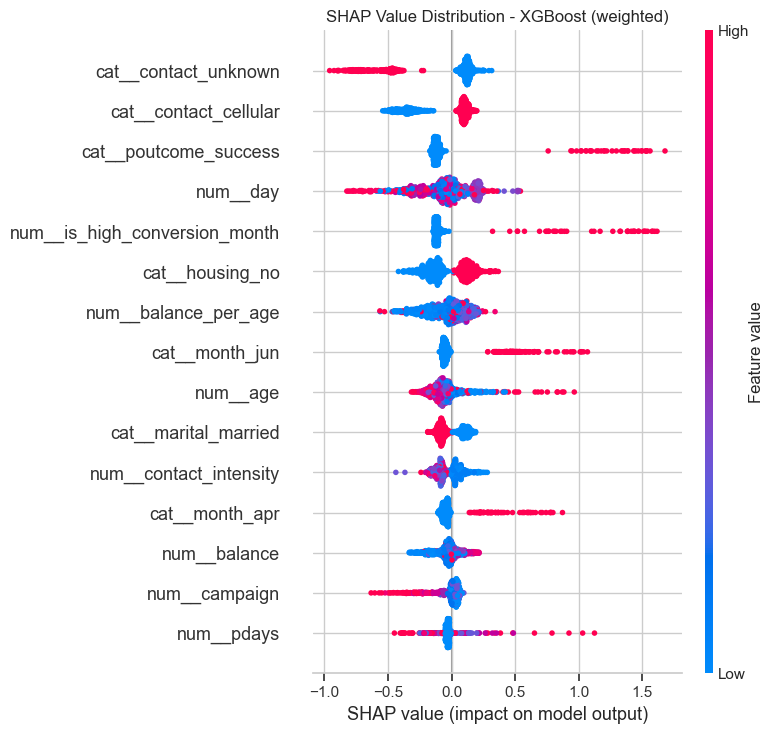

Saved: /Users/zihanghuang/data-mining/outputs/plots/shap_beeswarm.png


In [102]:
# Plot SHAP summary (beeswarm - shows feature value impact)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_display,
    X_sample,
    feature_names=feature_names,
    max_display=15,
    show=False,
)
plt.title(f"SHAP Value Distribution - {best_tree_model}")
plt.tight_layout()
shap_beeswarm_path = PLOTS_DIR / "shap_beeswarm.png"
plt.savefig(shap_beeswarm_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {shap_beeswarm_path}")